In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(data.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

In [6]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [7]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

#### Non-stage

In [8]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [9]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [10]:
# non_stages_supervised_cut

### N_out, N_in, K

In [11]:
# specify the number of lag hours
# n_hours = 72, stages_head.shape[1] + 
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [12]:
n_features

11

### Concatenation

In [13]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [14]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


### Train & Test set

In [15]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 76992


### Normalization

In [16]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model
- filters=64, kernel_size=12, activation='relu', Dense(32), epoch=2000 --> 0.0010
- filters=64, kernel_size=3, activation='relu', Dense(32), epoch=3000 --> 0.0008

In [29]:
# design network return_sequences=True, 
model_lstm_60 = keras.Sequential()
model_lstm_60.add(layers.LSTM(128, 
                              activation='relu', 
                              kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                              recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                              input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm_60.add(layers.Dropout(0.1))

model_lstm_60.add(layers.Dense(train_y.shape[1]))
model_lstm_60.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               71680     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 96)                12384     
Total params: 84,064
Trainable params: 84,064
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000

Epoch 00001: val_mae improved from inf to 1.84272, saving model to saved_model/lstm.h5
151/151 - 25s - loss: 0.1457 - mae: 0.3090 - val_loss: 232.5669 - val_mae: 1.8427
Epoch 2/2000

Epoch 00002: val_mae improved from 1.84272 to 0.15583, saving model to saved_model/lstm.h5
151/151 - 25s - loss: 0.0615 - mae: 0.1575 - val_loss: 0.0575 - val_mae: 0.1558
Epoch 3/2000

Epoch 00003: val_mae improved from 0.15583 to 0.13546, saving model to saved_model/lstm.h5
151/151 - 25s - loss: 0.0406 - mae: 0.1202 - val_loss: 0.0432 - val_mae: 0.1355
Epoch 4/2000

Epoch 00004: val_mae improved from 0.13546 to 0.13407, saving model to saved_model/lstm.h5
151/151 - 26s - loss: 0.0357 - mae: 0.1145 - val_loss: 0.0402 - val_mae: 0.1341
Epoch 5/2000

Epoch 00005: val_mae improved from 0.13407 to 0.13304, saving model to saved_model/lstm.h5
151/151 - 26s - loss: 0.0323 - mae: 0.1114 - val_loss: 0.0378 - val_mae: 0.1330
Epoch 6/2000

Epoch 00006: val_mae improved from 0.13304 to 0.13216, saving m

Epoch 49/2000

Epoch 00049: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0042 - mae: 0.0387 - val_loss: 0.0062 - val_mae: 0.0541
Epoch 50/2000

Epoch 00050: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0041 - mae: 0.0385 - val_loss: 0.0062 - val_mae: 0.0542
Epoch 51/2000

Epoch 00051: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0041 - mae: 0.0383 - val_loss: 0.0061 - val_mae: 0.0542
Epoch 52/2000

Epoch 00052: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0040 - mae: 0.0382 - val_loss: 0.0060 - val_mae: 0.0541
Epoch 53/2000

Epoch 00053: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0039 - mae: 0.0380 - val_loss: 0.0061 - val_mae: 0.0548
Epoch 54/2000

Epoch 00054: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0039 - mae: 0.0379 - val_loss: 0.0060 - val_mae: 0.0545
Epoch 55/2000

Epoch 00055: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0038 - mae: 0.0378 - val_loss: 0.0060 - v

Epoch 106/2000

Epoch 00106: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0060 - val_mae: 0.0592
Epoch 107/2000

Epoch 00107: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0025 - mae: 0.0331 - val_loss: 0.0060 - val_mae: 0.0591
Epoch 108/2000

Epoch 00108: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0025 - mae: 0.0331 - val_loss: 0.0061 - val_mae: 0.0595
Epoch 109/2000

Epoch 00109: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0025 - mae: 0.0330 - val_loss: 0.0061 - val_mae: 0.0596
Epoch 110/2000

Epoch 00110: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0025 - mae: 0.0330 - val_loss: 0.0060 - val_mae: 0.0593
Epoch 111/2000

Epoch 00111: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0025 - mae: 0.0329 - val_loss: 0.0060 - val_mae: 0.0592
Epoch 112/2000

Epoch 00112: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0025 - mae: 0.0329 - val_loss: 0.0

Epoch 163/2000

Epoch 00163: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0060 - val_mae: 0.0598
Epoch 164/2000

Epoch 00164: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0061 - val_mae: 0.0604
Epoch 165/2000

Epoch 00165: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0061 - val_mae: 0.0601
Epoch 166/2000

Epoch 00166: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0061 - val_mae: 0.0601
Epoch 167/2000

Epoch 00167: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0313 - val_loss: 0.0061 - val_mae: 0.0605
Epoch 168/2000

Epoch 00168: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0313 - val_loss: 0.0060 - val_mae: 0.0599
Epoch 169/2000

Epoch 00169: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0022 - mae: 0.0312 - val_loss: 0.0

Epoch 220/2000

Epoch 00220: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0064 - val_mae: 0.0624
Epoch 221/2000

Epoch 00221: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0064 - val_mae: 0.0623
Epoch 222/2000

Epoch 00222: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0065 - val_mae: 0.0629
Epoch 223/2000

Epoch 00223: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0064 - val_mae: 0.0625
Epoch 224/2000

Epoch 00224: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0065 - val_mae: 0.0629
Epoch 225/2000

Epoch 00225: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0064 - val_mae: 0.0625
Epoch 226/2000

Epoch 00226: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0

Epoch 277/2000

Epoch 00277: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0019 - mae: 0.0300 - val_loss: 0.0065 - val_mae: 0.0632
Epoch 278/2000

Epoch 00278: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0019 - mae: 0.0300 - val_loss: 0.0066 - val_mae: 0.0636
Epoch 279/2000

Epoch 00279: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0019 - mae: 0.0299 - val_loss: 0.0066 - val_mae: 0.0635
Epoch 280/2000

Epoch 00280: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0019 - mae: 0.0299 - val_loss: 0.0066 - val_mae: 0.0636
Epoch 281/2000

Epoch 00281: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0019 - mae: 0.0299 - val_loss: 0.0066 - val_mae: 0.0633
Epoch 282/2000

Epoch 00282: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0019 - mae: 0.0299 - val_loss: 0.0066 - val_mae: 0.0634
Epoch 283/2000

Epoch 00283: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0019 - mae: 0.0299 - val_loss: 0.0

Epoch 334/2000

Epoch 00334: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0064 - val_mae: 0.0625
Epoch 335/2000

Epoch 00335: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0064 - val_mae: 0.0625
Epoch 336/2000

Epoch 00336: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0064 - val_mae: 0.0624
Epoch 337/2000

Epoch 00337: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0295 - val_loss: 0.0064 - val_mae: 0.0625
Epoch 338/2000

Epoch 00338: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0063 - val_mae: 0.0621
Epoch 339/2000

Epoch 00339: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0064 - val_mae: 0.0626
Epoch 340/2000

Epoch 00340: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0

Epoch 391/2000

Epoch 00391: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0289 - val_loss: 0.0062 - val_mae: 0.0616
Epoch 392/2000

Epoch 00392: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0061 - val_mae: 0.0612
Epoch 393/2000

Epoch 00393: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0061 - val_mae: 0.0614
Epoch 394/2000

Epoch 00394: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0061 - val_mae: 0.0614
Epoch 395/2000

Epoch 00395: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0062 - val_mae: 0.0617
Epoch 396/2000

Epoch 00396: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0018 - mae: 0.0289 - val_loss: 0.0061 - val_mae: 0.0614
Epoch 397/2000

Epoch 00397: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0

Epoch 448/2000

Epoch 00448: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0059 - val_mae: 0.0600
Epoch 449/2000

Epoch 00449: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0059 - val_mae: 0.0603
Epoch 450/2000

Epoch 00450: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0059 - val_mae: 0.0601
Epoch 451/2000

Epoch 00451: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0059 - val_mae: 0.0601
Epoch 452/2000

Epoch 00452: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0059 - val_mae: 0.0600
Epoch 453/2000

Epoch 00453: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0058 - val_mae: 0.0597
Epoch 454/2000

Epoch 00454: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0

Epoch 505/2000

Epoch 00505: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0057 - val_mae: 0.0592
Epoch 506/2000

Epoch 00506: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0056 - val_mae: 0.0587
Epoch 507/2000

Epoch 00507: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0057 - val_mae: 0.0591
Epoch 508/2000

Epoch 00508: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0056 - val_mae: 0.0584
Epoch 509/2000

Epoch 00509: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0056 - val_mae: 0.0587
Epoch 510/2000

Epoch 00510: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0056 - val_mae: 0.0587
Epoch 511/2000

Epoch 00511: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0

Epoch 562/2000

Epoch 00562: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0576
Epoch 563/2000

Epoch 00563: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0574
Epoch 564/2000

Epoch 00564: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0056 - val_mae: 0.0586
Epoch 565/2000

Epoch 00565: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0055 - val_mae: 0.0581
Epoch 566/2000

Epoch 00566: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0574
Epoch 567/2000

Epoch 00567: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0055 - val_mae: 0.0582
Epoch 568/2000

Epoch 00568: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0279 - val_loss: 0.0

Epoch 619/2000

Epoch 00619: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0572
Epoch 620/2000

Epoch 00620: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0277 - val_loss: 0.0053 - val_mae: 0.0569
Epoch 621/2000

Epoch 00621: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0570
Epoch 622/2000

Epoch 00622: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0054 - val_mae: 0.0573
Epoch 623/2000

Epoch 00623: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0054 - val_mae: 0.0574
Epoch 624/2000

Epoch 00624: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0571
Epoch 625/2000

Epoch 00625: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0276 - val_loss: 0.0

Epoch 676/2000

Epoch 00676: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0054 - val_mae: 0.0573
Epoch 677/2000

Epoch 00677: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0052 - val_mae: 0.0566
Epoch 678/2000

Epoch 00678: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0052 - val_mae: 0.0565
Epoch 679/2000

Epoch 00679: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0052 - val_mae: 0.0561
Epoch 680/2000

Epoch 00680: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0053 - val_mae: 0.0568
Epoch 681/2000

Epoch 00681: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0052 - val_mae: 0.0564
Epoch 682/2000

Epoch 00682: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0

Epoch 733/2000

Epoch 00733: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0051 - val_mae: 0.0560
Epoch 734/2000

Epoch 00734: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0052 - val_mae: 0.0562
Epoch 735/2000

Epoch 00735: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0051 - val_mae: 0.0557
Epoch 736/2000

Epoch 00736: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0050 - val_mae: 0.0554
Epoch 737/2000

Epoch 00737: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0051 - val_mae: 0.0556
Epoch 738/2000

Epoch 00738: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0052 - val_mae: 0.0564
Epoch 739/2000

Epoch 00739: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0271 - val_loss: 0.0

Epoch 790/2000

Epoch 00790: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0051 - val_mae: 0.0558
Epoch 791/2000

Epoch 00791: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0049 - val_mae: 0.0548
Epoch 792/2000

Epoch 00792: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0050 - val_mae: 0.0551
Epoch 793/2000

Epoch 00793: val_mae did not improve from 0.05331
151/151 - 25s - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0051 - val_mae: 0.0554
Epoch 794/2000

Epoch 00794: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0050 - val_mae: 0.0552
Epoch 795/2000

Epoch 00795: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0268 - val_loss: 0.0050 - val_mae: 0.0553
Epoch 796/2000

Epoch 00796: val_mae did not improve from 0.05331
151/151 - 26s - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0

Epoch 847/2000

Epoch 00847: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0051 - val_mae: 0.0554
Epoch 848/2000

Epoch 00848: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0049 - val_mae: 0.0547
Epoch 849/2000

Epoch 00849: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0049 - val_mae: 0.0542
Epoch 850/2000

Epoch 00850: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0050 - val_mae: 0.0550
Epoch 851/2000

Epoch 00851: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0266 - val_loss: 0.0050 - val_mae: 0.0553
Epoch 852/2000

Epoch 00852: val_mae did not improve from 0.05331
151/151 - 28s - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0049 - val_mae: 0.0544
Epoch 853/2000

Epoch 00853: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0

Epoch 904/2000

Epoch 00904: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0049 - val_mae: 0.0545
Epoch 905/2000

Epoch 00905: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0048 - val_mae: 0.0537
Epoch 906/2000

Epoch 00906: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0050 - val_mae: 0.0551
Epoch 907/2000

Epoch 00907: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0048 - val_mae: 0.0541
Epoch 908/2000

Epoch 00908: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0049 - val_mae: 0.0547
Epoch 909/2000

Epoch 00909: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0048 - val_mae: 0.0538
Epoch 910/2000

Epoch 00910: val_mae did not improve from 0.05331
151/151 - 27s - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0

Epoch 959/2000

Epoch 00959: val_mae did not improve from 0.05275
151/151 - 27s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0047 - val_mae: 0.0533
Epoch 960/2000

Epoch 00960: val_mae did not improve from 0.05275
151/151 - 27s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0047 - val_mae: 0.0531
Epoch 961/2000

Epoch 00961: val_mae did not improve from 0.05275
151/151 - 28s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0046 - val_mae: 0.0530
Epoch 962/2000

Epoch 00962: val_mae did not improve from 0.05275
151/151 - 27s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0046 - val_mae: 0.0528
Epoch 963/2000

Epoch 00963: val_mae did not improve from 0.05275
151/151 - 27s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0047 - val_mae: 0.0532
Epoch 964/2000

Epoch 00964: val_mae did not improve from 0.05275
151/151 - 27s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0047 - val_mae: 0.0534
Epoch 965/2000

Epoch 00965: val_mae did not improve from 0.05275
151/151 - 27s - loss: 0.0015 - mae: 0.0263 - val_loss: 0.0

Epoch 1015/2000

Epoch 01015: val_mae did not improve from 0.05229
151/151 - 25s - loss: 0.0014 - mae: 0.0261 - val_loss: 0.0046 - val_mae: 0.0528
Epoch 1016/2000

Epoch 01016: val_mae did not improve from 0.05229
151/151 - 26s - loss: 0.0014 - mae: 0.0261 - val_loss: 0.0047 - val_mae: 0.0530
Epoch 1017/2000

Epoch 01017: val_mae did not improve from 0.05229
151/151 - 26s - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0047 - val_mae: 0.0533
Epoch 1018/2000

Epoch 01018: val_mae did not improve from 0.05229
151/151 - 25s - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0047 - val_mae: 0.0531
Epoch 1019/2000

Epoch 01019: val_mae did not improve from 0.05229
151/151 - 25s - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0046 - val_mae: 0.0529
Epoch 1020/2000

Epoch 01020: val_mae did not improve from 0.05229
151/151 - 25s - loss: 0.0014 - mae: 0.0261 - val_loss: 0.0046 - val_mae: 0.0529
Epoch 1021/2000

Epoch 01021: val_mae did not improve from 0.05229
151/151 - 25s - loss: 0.0014 - mae: 0.0261 - val_lo

Epoch 1071/2000

Epoch 01071: val_mae did not improve from 0.05209
151/151 - 25s - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0046 - val_mae: 0.0527
Epoch 1072/2000

Epoch 01072: val_mae did not improve from 0.05209
151/151 - 25s - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0046 - val_mae: 0.0529
Epoch 1073/2000

Epoch 01073: val_mae did not improve from 0.05209
151/151 - 25s - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0046 - val_mae: 0.0526
Epoch 1074/2000

Epoch 01074: val_mae did not improve from 0.05209
151/151 - 25s - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0046 - val_mae: 0.0526
Epoch 1075/2000

Epoch 01075: val_mae did not improve from 0.05209
151/151 - 25s - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0045 - val_mae: 0.0521
Epoch 1076/2000

Epoch 01076: val_mae improved from 0.05209 to 0.05206, saving model to saved_model/lstm.h5
151/151 - 25s - loss: 0.0014 - mae: 0.0260 - val_loss: 0.0045 - val_mae: 0.0521
Epoch 1077/2000

Epoch 01077: val_mae did not improve from 0.05206
151/151 - 

Epoch 1126/2000

Epoch 01126: val_mae did not improve from 0.05128
151/151 - 25s - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0520
Epoch 1127/2000

Epoch 01127: val_mae did not improve from 0.05128
151/151 - 25s - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0044 - val_mae: 0.0518
Epoch 1128/2000

Epoch 01128: val_mae did not improve from 0.05128
151/151 - 25s - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0520
Epoch 1129/2000

Epoch 01129: val_mae did not improve from 0.05128
151/151 - 25s - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0046 - val_mae: 0.0526
Epoch 1130/2000

Epoch 01130: val_mae did not improve from 0.05128
151/151 - 25s - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0523
Epoch 1131/2000

Epoch 01131: val_mae did not improve from 0.05128
151/151 - 25s - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0522
Epoch 1132/2000

Epoch 01132: val_mae did not improve from 0.05128
151/151 - 26s - loss: 0.0014 - mae: 0.0258 - val_lo

Epoch 1181/2000

Epoch 01181: val_mae did not improve from 0.05068
151/151 - 26s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0043 - val_mae: 0.0510
Epoch 1182/2000

Epoch 01182: val_mae did not improve from 0.05068
151/151 - 25s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0044 - val_mae: 0.0518
Epoch 1183/2000

Epoch 01183: val_mae did not improve from 0.05068
151/151 - 26s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0043 - val_mae: 0.0511
Epoch 1184/2000

Epoch 01184: val_mae did not improve from 0.05068
151/151 - 25s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0044 - val_mae: 0.0515
Epoch 1185/2000

Epoch 01185: val_mae did not improve from 0.05068
151/151 - 25s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0044 - val_mae: 0.0512
Epoch 1186/2000

Epoch 01186: val_mae did not improve from 0.05068
151/151 - 25s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0044 - val_mae: 0.0515
Epoch 1187/2000

Epoch 01187: val_mae did not improve from 0.05068
151/151 - 25s - loss: 0.0014 - mae: 0.0257 - val_lo

Epoch 1236/2000

Epoch 01236: val_mae improved from 0.05029 to 0.04994, saving model to saved_model/lstm.h5
151/151 - 27s - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0042 - val_mae: 0.0499
Epoch 1237/2000

Epoch 01237: val_mae did not improve from 0.04994
151/151 - 26s - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0043 - val_mae: 0.0509
Epoch 1238/2000

Epoch 01238: val_mae did not improve from 0.04994
151/151 - 26s - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0043 - val_mae: 0.0507
Epoch 1239/2000

Epoch 01239: val_mae did not improve from 0.04994
151/151 - 26s - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0043 - val_mae: 0.0507
Epoch 1240/2000

Epoch 01240: val_mae did not improve from 0.04994
151/151 - 26s - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0042 - val_mae: 0.0502
Epoch 1241/2000

Epoch 01241: val_mae did not improve from 0.04994
151/151 - 26s - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0043 - val_mae: 0.0508
Epoch 1242/2000

Epoch 01242: val_mae improved from 0.04994 to 0.04992, savin

Epoch 1291/2000

Epoch 01291: val_mae did not improve from 0.04955
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0042 - val_mae: 0.0500
Epoch 1292/2000

Epoch 01292: val_mae did not improve from 0.04955
151/151 - 27s - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0042 - val_mae: 0.0502
Epoch 1293/2000

Epoch 01293: val_mae did not improve from 0.04955
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0042 - val_mae: 0.0503
Epoch 1294/2000

Epoch 01294: val_mae did not improve from 0.04955
151/151 - 26s - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 1295/2000

Epoch 01295: val_mae did not improve from 0.04955
151/151 - 27s - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0042 - val_mae: 0.0504
Epoch 1296/2000

Epoch 01296: val_mae did not improve from 0.04955
151/151 - 27s - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0041 - val_mae: 0.0498
Epoch 1297/2000

Epoch 01297: val_mae improved from 0.04955 to 0.04952, saving model to saved_model/lstm.h5
151/151 - 

Epoch 1346/2000

Epoch 01346: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0041 - val_mae: 0.0498
Epoch 1347/2000

Epoch 01347: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 1348/2000

Epoch 01348: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 1349/2000

Epoch 01349: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0253 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 1350/2000

Epoch 01350: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 1351/2000

Epoch 01351: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0040 - val_mae: 0.0492
Epoch 1352/2000

Epoch 01352: val_mae did not improve from 0.04907
151/151 - 27s - loss: 0.0014 - mae: 0.0253 - val_lo

Epoch 1401/2000

Epoch 01401: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 1402/2000

Epoch 01402: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 1403/2000

Epoch 01403: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0040 - val_mae: 0.0489
Epoch 1404/2000

Epoch 01404: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0042 - val_mae: 0.0500
Epoch 1405/2000

Epoch 01405: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0253 - val_loss: 0.0041 - val_mae: 0.0492
Epoch 1406/2000

Epoch 01406: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0041 - val_mae: 0.0494
Epoch 1407/2000

Epoch 01407: val_mae did not improve from 0.04873
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_lo

Epoch 1456/2000

Epoch 01456: val_mae did not improve from 0.04822
151/151 - 27s - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0040 - val_mae: 0.0490
Epoch 1457/2000

Epoch 01457: val_mae did not improve from 0.04822
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0040 - val_mae: 0.0490
Epoch 1458/2000

Epoch 01458: val_mae did not improve from 0.04822
151/151 - 27s - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0039 - val_mae: 0.0485
Epoch 1459/2000

Epoch 01459: val_mae improved from 0.04822 to 0.04819, saving model to saved_model/lstm.h5
151/151 - 27s - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 1460/2000

Epoch 01460: val_mae did not improve from 0.04819
151/151 - 27s - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0041 - val_mae: 0.0494
Epoch 1461/2000

Epoch 01461: val_mae did not improve from 0.04819
151/151 - 27s - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 1462/2000

Epoch 01462: val_mae did not improve from 0.04819
151/151 - 

Epoch 1512/2000

Epoch 01512: val_mae did not improve from 0.04814
151/151 - 28s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0039 - val_mae: 0.0483
Epoch 1513/2000

Epoch 01513: val_mae did not improve from 0.04814
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0040 - val_mae: 0.0485
Epoch 1514/2000

Epoch 01514: val_mae did not improve from 0.04814
151/151 - 27s - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0039 - val_mae: 0.0483
Epoch 1515/2000

Epoch 01515: val_mae did not improve from 0.04814
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0040 - val_mae: 0.0490
Epoch 1516/2000

Epoch 01516: val_mae did not improve from 0.04814
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0040 - val_mae: 0.0488
Epoch 1517/2000

Epoch 01517: val_mae did not improve from 0.04814
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 1518/2000

Epoch 01518: val_mae did not improve from 0.04814
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_lo

Epoch 1567/2000

Epoch 01567: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0039 - val_mae: 0.0484
Epoch 1568/2000

Epoch 01568: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0039 - val_mae: 0.0485
Epoch 1569/2000

Epoch 01569: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 1570/2000

Epoch 01570: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 1571/2000

Epoch 01571: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0040 - val_mae: 0.0489
Epoch 1572/2000

Epoch 01572: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0250 - val_loss: 0.0040 - val_mae: 0.0488
Epoch 1573/2000

Epoch 01573: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_lo

Epoch 1623/2000

Epoch 01623: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 1624/2000

Epoch 01624: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0039 - val_mae: 0.0484
Epoch 1625/2000

Epoch 01625: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0039 - val_mae: 0.0484
Epoch 1626/2000

Epoch 01626: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0040 - val_mae: 0.0487
Epoch 1627/2000

Epoch 01627: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0039 - val_mae: 0.0481
Epoch 1628/2000

Epoch 01628: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0038 - val_mae: 0.0478
Epoch 1629/2000

Epoch 01629: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_lo

Epoch 1679/2000

Epoch 01679: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0039 - val_mae: 0.0479
Epoch 1680/2000

Epoch 01680: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0039 - val_mae: 0.0481
Epoch 1681/2000

Epoch 01681: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0039 - val_mae: 0.0483
Epoch 1682/2000

Epoch 01682: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0038 - val_mae: 0.0476
Epoch 1683/2000

Epoch 01683: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0039 - val_mae: 0.0479
Epoch 1684/2000

Epoch 01684: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0038 - val_mae: 0.0477
Epoch 1685/2000

Epoch 01685: val_mae did not improve from 0.04740
151/151 - 27s - loss: 0.0013 - mae: 0.0248 - val_lo

Epoch 1734/2000

Epoch 01734: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0038 - val_mae: 0.0474
Epoch 1735/2000

Epoch 01735: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 1736/2000

Epoch 01736: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0038 - val_mae: 0.0476
Epoch 1737/2000

Epoch 01737: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 1738/2000

Epoch 01738: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0038 - val_mae: 0.0473
Epoch 1739/2000

Epoch 01739: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0038 - val_mae: 0.0476
Epoch 1740/2000

Epoch 01740: val_mae did not improve from 0.04699
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_lo

Epoch 1790/2000

Epoch 01790: val_mae did not improve from 0.04685
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0039 - val_mae: 0.0483
Epoch 1791/2000

Epoch 01791: val_mae did not improve from 0.04685
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0038 - val_mae: 0.0474
Epoch 1792/2000

Epoch 01792: val_mae did not improve from 0.04685
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0037 - val_mae: 0.0470
Epoch 1793/2000

Epoch 01793: val_mae did not improve from 0.04685
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0038 - val_mae: 0.0477
Epoch 1794/2000

Epoch 01794: val_mae did not improve from 0.04685
151/151 - 26s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0039 - val_mae: 0.0478
Epoch 1795/2000

Epoch 01795: val_mae did not improve from 0.04685
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 1796/2000

Epoch 01796: val_mae did not improve from 0.04685
151/151 - 27s - loss: 0.0013 - mae: 0.0247 - val_lo

Epoch 1845/2000

Epoch 01845: val_mae did not improve from 0.04650
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0038 - val_mae: 0.0472
Epoch 1846/2000

Epoch 01846: val_mae did not improve from 0.04650
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0038 - val_mae: 0.0471
Epoch 1847/2000

Epoch 01847: val_mae did not improve from 0.04650
151/151 - 26s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0037 - val_mae: 0.0471
Epoch 1848/2000

Epoch 01848: val_mae did not improve from 0.04650
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0038 - val_mae: 0.0475
Epoch 1849/2000

Epoch 01849: val_mae did not improve from 0.04650
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 1850/2000

Epoch 01850: val_mae did not improve from 0.04650
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0038 - val_mae: 0.0472
Epoch 1851/2000

Epoch 01851: val_mae did not improve from 0.04650
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_lo

Epoch 1901/2000

Epoch 01901: val_mae did not improve from 0.04640
151/151 - 26s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0037 - val_mae: 0.0467
Epoch 1902/2000

Epoch 01902: val_mae did not improve from 0.04640
151/151 - 26s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0037 - val_mae: 0.0467
Epoch 1903/2000

Epoch 01903: val_mae did not improve from 0.04640
151/151 - 26s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0038 - val_mae: 0.0475
Epoch 1904/2000

Epoch 01904: val_mae did not improve from 0.04640
151/151 - 27s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0038 - val_mae: 0.0472
Epoch 1905/2000

Epoch 01905: val_mae did not improve from 0.04640
151/151 - 26s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0038 - val_mae: 0.0471
Epoch 1906/2000

Epoch 01906: val_mae did not improve from 0.04640
151/151 - 27s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0038 - val_mae: 0.0472
Epoch 1907/2000

Epoch 01907: val_mae did not improve from 0.04640
151/151 - 26s - loss: 0.0013 - mae: 0.0245 - val_lo

Epoch 1956/2000

Epoch 01956: val_mae did not improve from 0.04584
151/151 - 27s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0036 - val_mae: 0.0463
Epoch 1957/2000

Epoch 01957: val_mae did not improve from 0.04584
151/151 - 26s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0036 - val_mae: 0.0462
Epoch 1958/2000

Epoch 01958: val_mae did not improve from 0.04584
151/151 - 27s - loss: 0.0013 - mae: 0.0244 - val_loss: 0.0037 - val_mae: 0.0470
Epoch 1959/2000

Epoch 01959: val_mae improved from 0.04584 to 0.04581, saving model to saved_model/lstm.h5
151/151 - 27s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0036 - val_mae: 0.0458
Epoch 1960/2000

Epoch 01960: val_mae did not improve from 0.04581
151/151 - 27s - loss: 0.0013 - mae: 0.0244 - val_loss: 0.0037 - val_mae: 0.0467
Epoch 1961/2000

Epoch 01961: val_mae did not improve from 0.04581
151/151 - 27s - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0037 - val_mae: 0.0468
Epoch 1962/2000

Epoch 01962: val_mae did not improve from 0.04581
151/151 - 

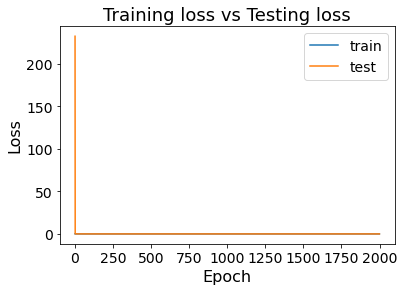

In [30]:
lr = 0.00005
EPOCHS = 2000
model_lstm_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('../saved_model/lstm.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_lstm_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                               callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [60]:
from tensorflow.keras.models import load_model

model_load = load_model('../saved_model/lstm.h5')

In [80]:
yhat = model_load.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

602/602 [==============================] - 1s 813us/step
inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [83]:
# inv_y

In [84]:
# inv_yhat

In [85]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [86]:
error = inv_yhat - inv_y
# error

In [87]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [88]:
len(error_19_20)

17544

In [77]:
inv_y.to_csv('../output/inv_y_lstm.csv')
inv_yhat.to_csv('../output/inv_yhat_lstm.csv')
error.to_csv('../output/error_lstm.csv')

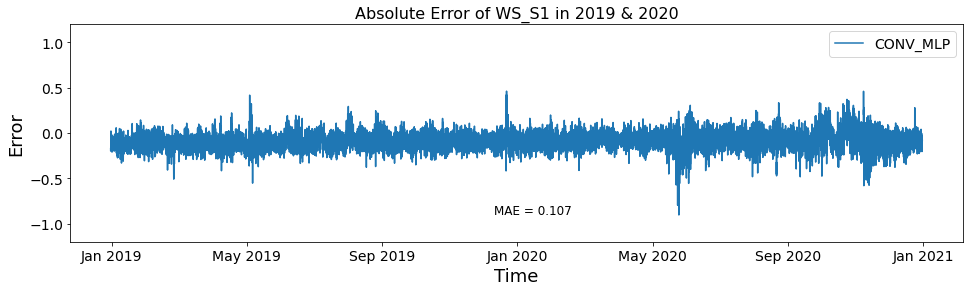

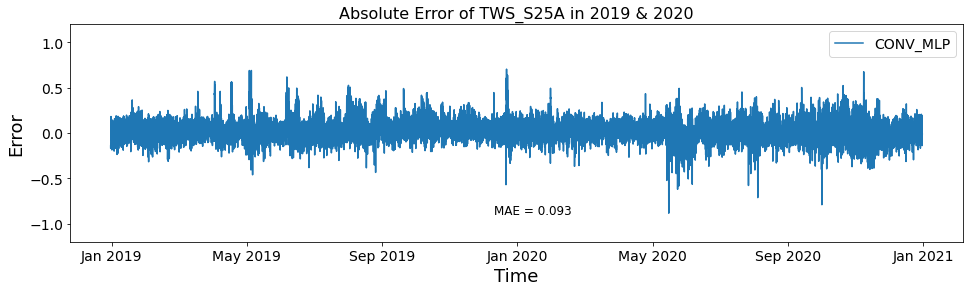

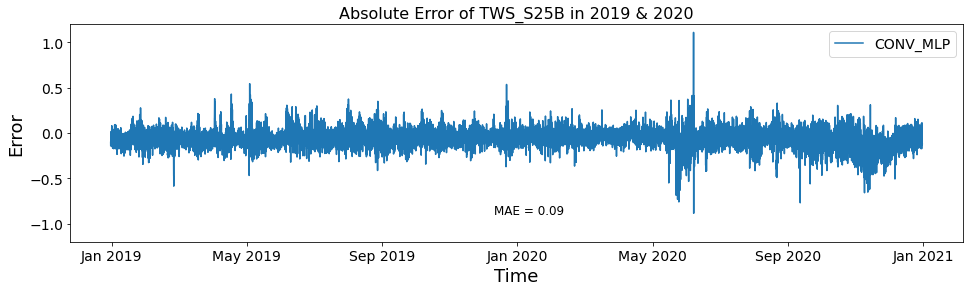

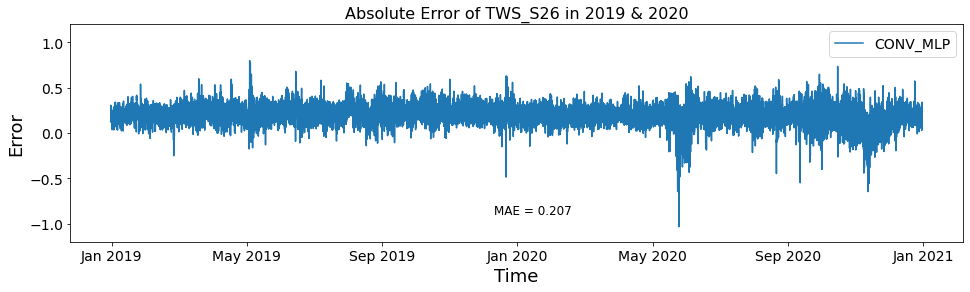

In [89]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
# locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26', 'STORAGE', 'HWS_S25A', 'HWS_S25B']
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([-4, -3, -2, -1]):
    plt.plot(error.iloc[-17544:, col], label='CONV_MLP')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.2, 1.2)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -0.9, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()